Я выбрала для выполнения классификации с помощью свёрточной сети набор данных KMNIST - иероглифы кузусидзи

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchvision as tv
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [2]:
BATCH_SIZE=64

In [3]:
train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 18.2M/18.2M [00:11<00:00, 1.60MB/s]


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 280kB/s]


Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



100%|██████████| 3.04M/3.04M [00:02<00:00, 1.24MB/s]


Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 13.6MB/s]

Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw



In [4]:
train_dataset.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

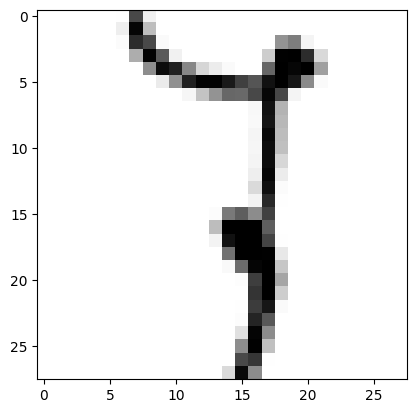

In [5]:
plt.imshow(train_dataset[123][0].numpy().squeeze(), cmap='gray_r')

In [6]:
train_dataset[123][0].numpy().shape

(1, 28, 28)

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [8]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size([1, 50])
Layer Linear(in_features=50, out_features=10, bias=True). X shape: torch.Size([1, 10])


In [9]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [10]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [11]:
model = model.to(dev)

In [12]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [13]:
def train_model(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [14]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.6025, train acc 0.803, test acc 0.832
epoch 2, loss 0.1904, train acc 0.941, test acc 0.876
epoch 3, loss 0.1323, train acc 0.959, test acc 0.898
epoch 4, loss 0.1046, train acc 0.968, test acc 0.905
epoch 5, loss 0.0865, train acc 0.974, test acc 0.919
epoch 6, loss 0.0750, train acc 0.977, test acc 0.923
epoch 7, loss 0.0649, train acc 0.980, test acc 0.925
epoch 8, loss 0.0576, train acc 0.982, test acc 0.927
epoch 9, loss 0.0498, train acc 0.985, test acc 0.936
epoch 10, loss 0.0451, train acc 0.986, test acc 0.930
CPU times: user 1min 25s, sys: 585 ms, total: 1min 25s
Wall time: 1min 27s


Вывод: значение функции потерь быстро уменьшается. При самом удачном запуске точность на тестовой выборке достигла 93%, что является хорошим показателем. В среднем - 91%. Можно улучшить показатели за счёт свёрточной сети

In [15]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=5, padding=2),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=2),
    nn.MaxPool2d(2, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.BatchNorm1d(4608),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 10),
).to(dev)
lr, num_epochs = 0.0003, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.2184, train acc 0.932, test acc 0.907
epoch 2, loss 0.0840, train acc 0.974, test acc 0.931
epoch 3, loss 0.0638, train acc 0.980, test acc 0.939
epoch 4, loss 0.0466, train acc 0.986, test acc 0.947
epoch 5, loss 0.0413, train acc 0.987, test acc 0.947
epoch 6, loss 0.0365, train acc 0.989, test acc 0.949
epoch 7, loss 0.0322, train acc 0.990, test acc 0.955
epoch 8, loss 0.0285, train acc 0.990, test acc 0.956
epoch 9, loss 0.0235, train acc 0.993, test acc 0.959
epoch 10, loss 0.0223, train acc 0.993, test acc 0.956
CPU times: user 1min 54s, sys: 534 ms, total: 1min 54s
Wall time: 1min 55s


Вывод: модель обучается более эффективно и достигает более высоких точностей на тестовой выборке. Уже с первого запуска точность >90%, а средний показатель достиг 94% примерно. Итак, высокий уровень точности достигнут

In [16]:
y_true = []
y_pred_2 = []
for X, y in test:
  X, y = X.to(dev), y.to(dev)
  y_pred_1 = model(X)
  y_true.extend(y)
  y_pred_2.extend(y_pred_1.argmax(dim=1))

In [17]:
y_true = [i.item() for i in y_true]
y_pred_2 = [i.item() for i in y_pred_2]

In [18]:
conf_mx = confusion_matrix(y_true, y_pred_2, normalize="pred")

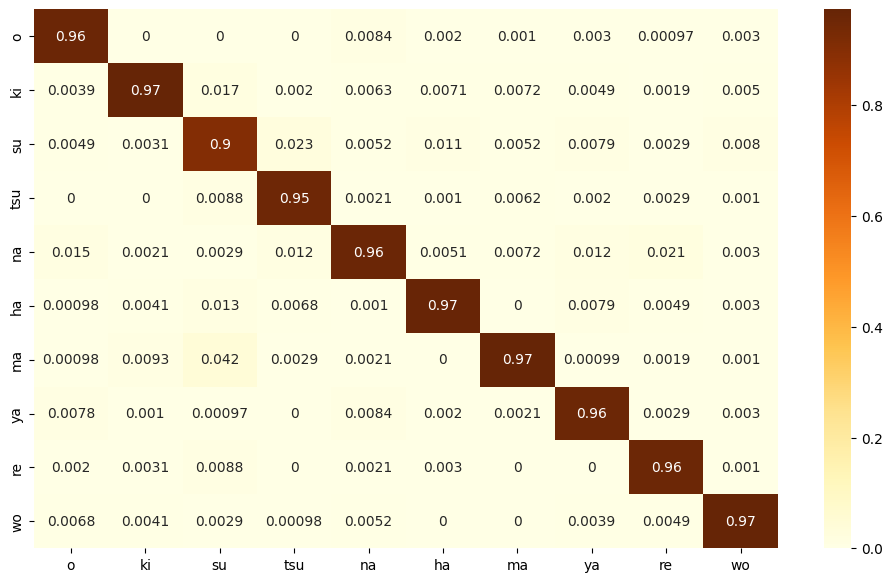

In [19]:
df_cm = pd.DataFrame(conf_mx, index=test_dataset.class_to_idx,
                     columns=test_dataset.classes)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr");

Сильной путаницы между парами иероглифов не видно. Можно только выделить o, na и ki, su, ma, которые чаще остальных модель классифицирует ошибочно. Диагональные элементы определены точно, их показатель >0,92

Попробую изменить гиперпараметры, чтобы ещё улучшить показатели

In [20]:
BATCH_SIZE=128

In [21]:
train_dataset = tv.datasets.KMNIST(
    root='.', train=True, transform=tv.transforms.ToTensor(), download=True
)
test_dataset = tv.datasets.KMNIST(
    root='.', train=False, transform=tv.transforms.ToTensor(), download=True
)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [22]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Flatten(),
    nn.Linear(256 * 3 * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 10),
).to(dev)
lr, num_epochs = 0.0001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time train_model(model, train, test, trainer, num_epochs)

epoch 1, loss 0.4543, train acc 0.870, test acc 0.880
epoch 2, loss 0.1089, train acc 0.969, test acc 0.919
epoch 3, loss 0.0658, train acc 0.982, test acc 0.938
epoch 4, loss 0.0438, train acc 0.987, test acc 0.942
epoch 5, loss 0.0308, train acc 0.991, test acc 0.948
epoch 6, loss 0.0210, train acc 0.994, test acc 0.947
epoch 7, loss 0.0174, train acc 0.995, test acc 0.948
epoch 8, loss 0.0130, train acc 0.997, test acc 0.950
epoch 9, loss 0.0094, train acc 0.997, test acc 0.952
epoch 10, loss 0.0098, train acc 0.997, test acc 0.954
CPU times: user 1min 51s, sys: 353 ms, total: 1min 51s
Wall time: 1min 57s


Модель показала хорошие результата, можно отметить, что точность на тестовой выборке начиная с 3 запуска стабильно держит высокий уровень, однако по сравнению с предыдущем не увеличила среднее значение точности, что говорит о том, что выбор гиперпараметров в прошлом обучении был оптимальным.